# Etapa 1

## 1.1 Entendimiento del negocio y enfoque analítico

### 1.1.1 Oportunidad/Problema negocio

Categorizar los comentarios de las peliculas en positivos o negativos


### 1.1.2 Enfoque analítico

(Descripción del
requerimiento desde el
punto de vista de
aprendizaje automático)

Uso de tecnicas de aprendizaje automatico(machine learning) y procesamiento de lenguaje natural que tienen como objetivo principal procesar de manera automatica grandes cantidades de texto de los comentarios de las peliculas para poder clasificarlos en positivos o negativos


### 1.1.3 Organización y rol dentro de ella que se beneficia con la oportunidad definida

### 1.1.4 Técnicas y algoritmos a utilizar

a.) Tipo de aprendizaje : supervisado

b.) Tarea de aprendizaje : Clasificación 

c.) Tecnicas de aprendizaje : 

        1. SVM(Máquinas de vectores de soporte)
        2. Regresión logística
        3. Arboles de decisión


## 1.2 Entendimiento y preparación de los datos

### 1.2.1 Carga de los datos

In [89]:
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
# from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
import contractions
import inflect
import pandas_profiling
import re
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn import tree
import dill as pickle
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import SnowballStemmer
from sklearn.pipeline import FunctionTransformer




import warnings
warnings.filterwarnings('ignore')


nltk.data.path.append(os.path.abspath('./nltk_data'))
nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('stopwords', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='./nltk_data')
ROOT_DIR = os.path.abspath(os.curdir)
NLTK_DATA_DIR = os.path.join(ROOT_DIR, 'nltk_data')
nltk.data.path.append(NLTK_DATA_DIR)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stopwords_spanish = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()

df_movies = pd.read_csv('./data/MovieReviews.csv',
                        sep=',',
                        encoding='utf-8',
                        index_col=0)

# random_df = df_movies.sample(n=len(df_movies), replace=True)
# random_df.to_csv("./data/randomMovieReviews.csv", index=False)

# df_movies = pd.read_csv('./data/randomMovieReviews.csv',
#                         sep=',',
#                         encoding='utf-8',
#                         index_col=None)º

### 1.2.2 Entendimiento de los datos

In [90]:
df_movies.shape

(5000, 2)

In [91]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo


In [92]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    5000 non-null   object
 1   sentimiento  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [93]:
# Se calcula el porcentaje de los valores nulos por columna
print((df_movies.isnull().sum()*100 / df_movies.shape[0]).sort_values(ascending=False))

review_es      0.0
sentimiento    0.0
dtype: float64


In [94]:
# Analizar la duplicidad de los datos
df_movies.duplicated().sum()

2

<Axes: xlabel='sentimiento'>

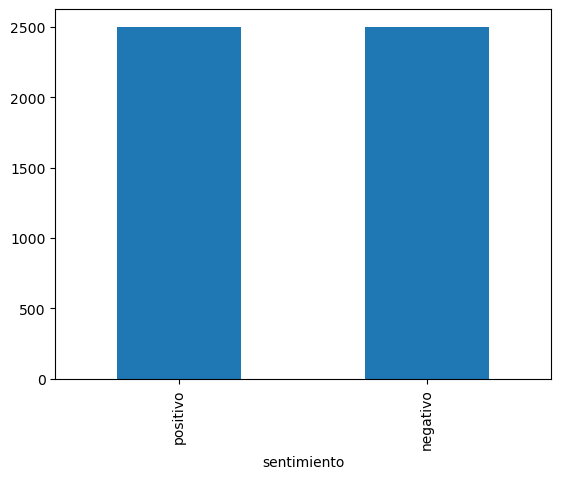

In [95]:
# Analizar distribución de la variable categórica
df_movies['sentimiento'].value_counts().plot(kind='bar')

In [96]:
# Para analizar la columna de review_es vamos a ver los reviews con menos de 30 caracteres
short_reviews = df_movies[df_movies['review_es'].str.len() < 50]
print(short_reviews)

Empty DataFrame
Columns: [review_es, sentimiento]
Index: []


Como puede evidenciarse, no hay filas con reviews cortos o vacíos que se podrían considerar como atípicos.

In [97]:
short_reviews = df_movies[df_movies['review_es'].str.len() < 61]
print(short_reviews)

# El review más corto tiene 61 caracteres, lo cual es un número apropiado.
print(short_reviews['review_es'])

                                              review_es sentimiento
4421  Esta película es terrible pero tiene algunos b...    negativo
4421    Esta película es terrible pero tiene algunos b...
Name: review_es, dtype: object


### 1.2.3 Preparación de los datos

In [98]:
# Se cambian los valores a numéricos
df_movies['sentimiento'] = df_movies['sentimiento'].replace({'positivo': 1, 'negativo': 0})

In [99]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1


In [100]:
df_movies.dtypes

review_es      object
sentimiento     int64
dtype: object

sentimiento
1    2500
0    2500
Name: count, dtype: int64


<Axes: xlabel='sentimiento'>

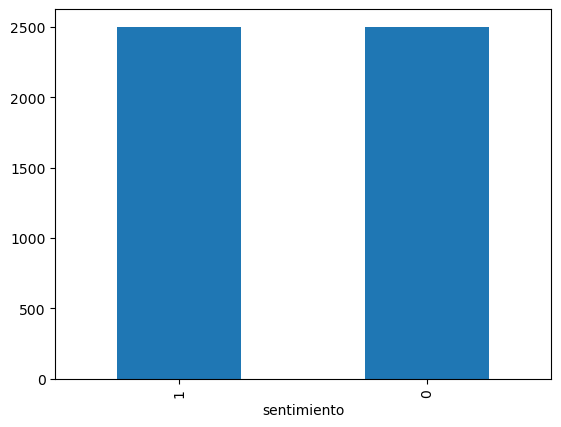

In [101]:
# Analizar distribución de la variable categórica
print(df_movies['sentimiento'].value_counts())
df_movies['sentimiento'].value_counts().plot(kind='bar',)

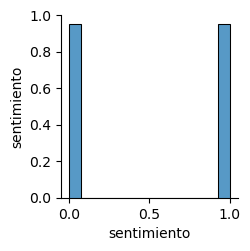

In [102]:
sns.pairplot(df_movies)

Finalmente, se eliminan los valores duplicados, los cuales solo eran 2.

In [103]:
print("Cantidad de datos duplicados: ",df_movies.duplicated().sum())
df_movies.drop_duplicates(inplace=True)
print("Cantidad de datos duplicados después: ",df_movies.duplicated().sum())

df_movies.shape

Cantidad de datos duplicados:  2
Cantidad de datos duplicados después:  0


(4998, 2)

En conclusión, se tienen 4998 filas para crear el modelo.

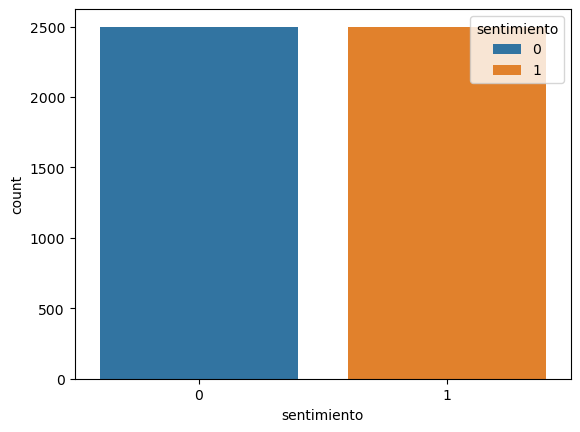

In [104]:
ax = sns.countplot(x="sentimiento", hue="sentimiento", data=df_movies, dodge=False)

In [105]:
df_movies.head(20)

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1
5,Así como un fanático de la vida de las películ...,1
6,"El polvo rojo está bien actuado y bien hecho, ...",1
7,Los talentos de Abbott y Costello brillan en l...,1
8,Asesina sexy Tiffany (Jennifer Tilly) todavía ...,1
9,"Si mis expectativas no se superaron, ciertamen...",1


### 1.2.4 Procesamiento de lenguaje natural

In [106]:

def preprocessor(text):
     text = re.sub('<[^>]*>', '', text)
     emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                            text)
     text = (re.sub('[\W]+', ' ', text.lower()) +
             ' '.join(emoticons).replace('-', ''))
     return text

In [107]:
df_movies['review_es'] = df_movies['review_es'].apply(preprocessor)

In [108]:
df_movies.head(20)

,review_es,sentimiento
0,si está buscando una película de guerra típica...,1
1,supongo que algunos directores de películas de...,1
2,es difícil contarle más sobre esta película si...,1
3,la película comienza muy lentamente con el est...,1
4,esta película es verdadera acción en su máxima...,1
5,así como un fanático de la vida de las películ...,1
6,el polvo rojo está bien actuado y bien hecho p...,1
7,los talentos de abbott y costello brillan en l...,1
8,asesina sexy tiffany jennifer tilly todavía an...,1
9,si mis expectativas no se superaron ciertament...,1


In [109]:

# nltk.download('stopwords')
# stop_words= set(stopwords.words('spanish'))

In [110]:
# # Función para tokenizar los tweets
# def tokenizer(text):
#     tt = TweetTokenizer()
#     return tt.tokenize(text)

In [111]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, Y_train, Y_test = train_test_split(df_movies['review_es'], df_movies['sentimiento'], test_size = 0.3, stratify = df_movies['sentimiento'], random_state = 1)

In [112]:
X_train.shape

(3498,)

In [113]:
pd.Series(Y_train).value_counts(normalize = True)

sentimiento
1    0.5
0    0.5
Name: proportion, dtype: float64

In [114]:
X_test.shape

(1500,)

In [115]:
pd.Series(Y_test).value_counts(normalize = True)

sentimiento
1    0.5
0    0.5
Name: proportion, dtype: float64

## Vectorización

In [116]:
bow = CountVectorizer(tokenizer = word_tokenize, stop_words = stopwords_spanish, lowercase = True)


In [117]:
X_bow = bow.fit_transform(X_train)

In [118]:
len(bow.vocabulary_)

47121

In [119]:
tfidf=TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords_spanish, lowercase=True)

In [120]:
X_tfidf = tfidf.fit_transform(X_train)

In [121]:
len(tfidf.vocabulary_)

47121

## 1.3 Modelo y evaluación
Se requiere que llas variables de entrada estén separadas de la variable objetivo.

### 1.3.1 Modelo con Support Vector Machines (SVMs)

#### 1.3.1.1 Construcción del modelo BOW

In [122]:
# # Create a svm Classifier
# bow_clf = svm.SVC(kernel='linear') # Linear Kernel

# # Entrenar el modelo utilizando X_box y Y_train
# bow_clf.fit(X_bow, Y_train)

# y_train_bow_predict = bow_clf.predict(X_bow)
# y_test_bow_predict = bow_clf.predict(bow.transform(X_test))

In [123]:
# metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_predict)

In [124]:
# metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_bow_predict)

In [125]:
# if len(bow_clf.classes_) == 2:
#     print('Precision:', metrics.precision_score(Y_train, y_train_bow_predict, pos_label = 1))
#     print('Recall:', metrics.recall_score(Y_train, y_train_bow_predict, pos_label = 1))
#     print('F1:', metrics.f1_score(Y_train, y_train_bow_predict, pos_label = 1))
# else:
#     # Para casos no binarios, es común calcular las métricas para cada clase
#     print('Precision:', metrics.precision_score(Y_train, y_train_bow_predict, average = None))
#     print('Recall:', metrics.recall_score(Y_train, y_train_bow_predict, average = None))
#     print('F1:', metrics.f1_score(Y_train, y_train_bow_predict, average = None))

In [126]:
# if len(bow_clf.classes_) == 2:
#     print('Precision:', metrics.precision_score(Y_test, y_test_bow_predict, pos_label = 1))
#     print('Recall:', metrics.recall_score(Y_test, y_test_bow_predict, pos_label = 1))
#     print('F1:', metrics.f1_score(Y_test, y_test_bow_predict, pos_label = 1))
# else:
#     # Para casos no binarios, es común calcular las métricas para cada clase
#     print('Precision:', metrics.precision_score(Y_test, y_test_bow_predict, average = None))
#     print('Recall:', metrics.recall_score(Y_test, y_test_bow_predict, average = None))
#     print('F1:', metrics.f1_score(Y_test, y_test_bow_predict, average = None))

#### 1.3.1.2 Construcción del modelo con TD-IDF

In [127]:
# tfidf_clf = svm.SVC(kernel='linear') # Linear Kernel

# tfidf_clf.fit(X_tfidf, Y_train)

In [128]:
# y_train_tfidf_predict = tfidf_clf.predict(X_tfidf)
# y_test_tfidf_predict = tfidf_clf.predict(tfidf.transform(X_test))

In [129]:
# metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_predict)

In [130]:
# metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_predict)

In [131]:
# if len(bow_clf.classes_) == 2:
#     print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_predict, pos_label = 1))
#     print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_predict, pos_label = 1))
#     print('F1:', metrics.f1_score(Y_train, y_train_tfidf_predict, pos_label = 1))
# else:
#     # Para casos no binarios, es común calcular las métricas para cada clase
#     print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_predict, average = None))
#     print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_predict, average = None))
#     print('F1:', metrics.f1_score(Y_train, y_train_tfidf_predict, average = None))

In [132]:
# if len(tfidf_clf.classes_) == 2:
#     print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_predict, pos_label = 1))
#     print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_predict, pos_label = 1))
#     print('F1:', metrics.f1_score(Y_test, y_test_tfidf_predict, pos_label = 1))
# else:
#     # Para casos no binarios, es común calcular las métricas para cada clase
#     print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_predict, average = None))
#     print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_predict, average = None))
#     print('F1:', metrics.f1_score(Y_test, y_test_tfidf_predict, average = None))

#### 1.3.1.3 Análisis del error

In [133]:
# error_df = pd.concat([
#     pd.concat([X_test, Y_test], axis = 1).reset_index(),
#     pd.Series(y_test_tfidf_predict)
# ], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

# error_df.drop('index', inplace = True, axis = 1)

In [134]:
# error_df.loc[error_df['actual'] != error_df['predicted']].shape

In [135]:
# error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

### 1.3.2 Modelo con Regresión logistica

In [136]:

bow_model=LogisticRegression(random_state=2)

In [137]:
bow_model.fit(X_bow, Y_train)

LogisticRegression(random_state=2)

In [138]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

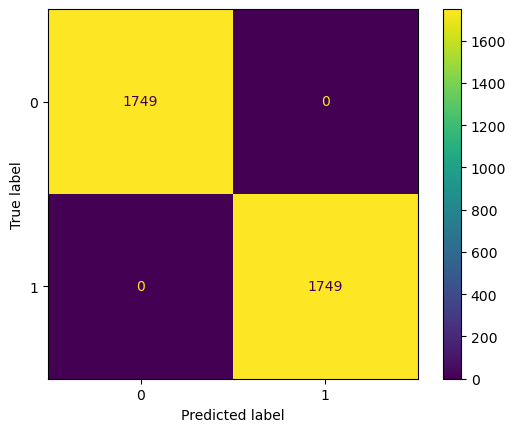

In [139]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_predict)

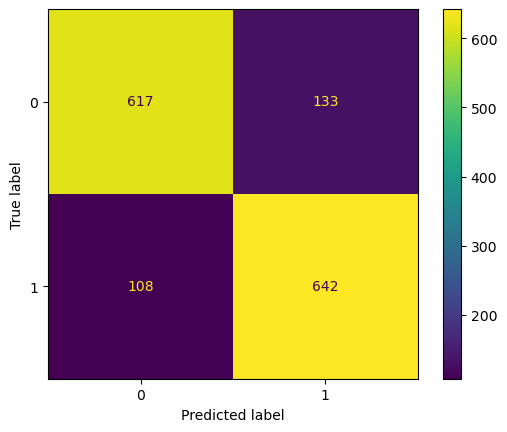

In [140]:
metrics.ConfusionMatrixDisplay.from_predictions( Y_test,y_test_bow_predict)

In [141]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(Y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(Y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(Y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [142]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(Y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(Y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(Y_test, y_test_bow_predict, average = None))

Precision: 0.8283870967741935
Recall: 0.856
F1: 0.8419672131147541


#### 1.3.2.2 Modelo usando TF-IDF

In [143]:
tfidf_model = LogisticRegression(random_state = 3)

In [144]:
tfidf_model.fit(X_tfidf, Y_train)

LogisticRegression(random_state=3)

In [145]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

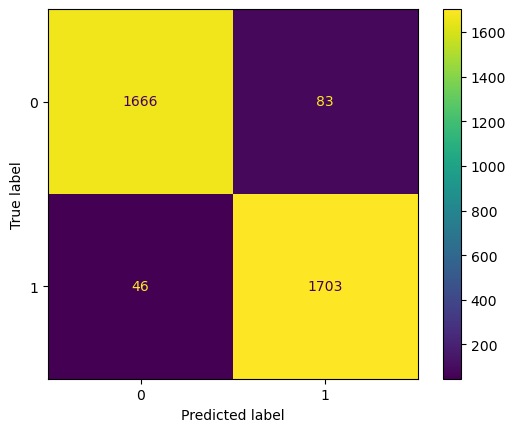

In [146]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_predict)

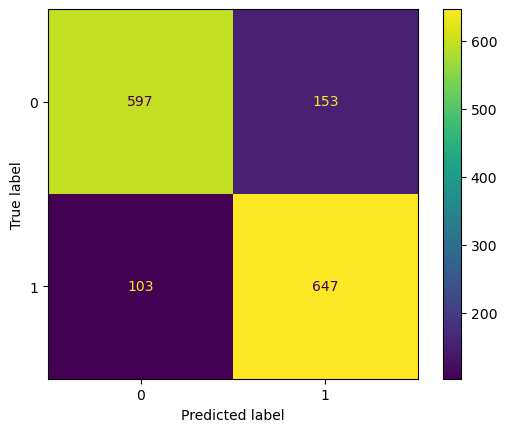

In [147]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_predict)

In [148]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(Y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(Y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(Y_train, y_train_tfidf_predict, average = None))

Precision: 0.9535274356103024
Recall: 0.9736992567181246
F1: 0.9635077793493635


In [149]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(Y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(Y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(Y_test, y_test_tfidf_predict, average = None))

Precision: 0.80875
Recall: 0.8626666666666667
F1: 0.8348387096774194


#### 1.3.2.3 Análisis del error

In [150]:
error_df = pd.concat([
    pd.concat([X_test, Y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict)
], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [151]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(256, 3)

In [152]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,review_es,actual,predicted
1347,esta película es una linda y linda película or...,1,0
749,i picked this title up from a friend who had i...,0,1
84,esperaba que esto fuera del calibre de das boo...,0,1
1353,parece que todos quieren saltar al carro y dec...,1,0
626,alguien recuerda la comedia alternativa muest...,0,1
965,lifeforce es una película extremadamente esqui...,1,0
924,desafortunadamente tengo que estar de acuerdo ...,0,1
1128,fui un gran fanático de snl en los días de che...,0,1
1462,hay tantas declaraciones incorrectas en este l...,0,1
182,si conocía a brad lineweaver en el estado de f...,0,1


#### Crear clase para pre procesamiento e incluirla en Pipeline

In [153]:

pipeline = Pipeline([
    # ('preprocessor', TextProcesser()),
    ('vectorizer', TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords_spanish)),
    ('classifier', LogisticRegression(random_state=2))
])

In [154]:
param_grid = {
    'vectorizer': [CountVectorizer(tokenizer = word_tokenize, stop_words = stopwords_spanish), TfidfVectorizer(tokenizer = word_tokenize, stop_words = stopwords_spanish)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1,1,10],
}

In [155]:
#search = GridSearchCV(pipeline, param_grid, scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, return_train_score = True, verbose = 1, n_jobs = -1)

In [156]:
#search.fit(X_train, Y_train)

In [157]:
#search.best_params_

In [158]:
#search.best_score_

In [159]:
#y_test_search_predict = search.best_estimator_.predict(X_test)

In [160]:
filename='./api/assets/logistic_regression.pkl'

In [161]:
print(pipeline)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 tokenizer=<function word_tokenize at 0x7efc0681f430>)),
                ('classifier', LogisticRegression(random_state=2))])


In [162]:
pipeline.fit(X_train, Y_train)
with open(filename, 'wb') as f:
    pickle.dump(pipeline, f)

In [163]:
with open(filename, 'rb') as f:
    pipeline_loaded = pickle.load(f)

In [164]:
pipeline_loaded.predict(X_test)

array([1, 0, 0, ..., 1, 1, 1])

In [165]:
#metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_search_predict)

In [166]:
#accuracy = accuracy_score(Y_test, y_test_search_predict)
#print('Accuracy:', accuracy)
#print('Precision:', precision_score(Y_test, y_test_search_predict))
#print('Recall:', recall_score(Y_test, y_test_search_predict))
#print('F1:', f1_score(Y_test, y_test_search_predict))

### 1.3.3 Arboles de decisión

In [167]:
# # Crear la matriz de características TF-IDF
# tfidf_vectorizer = TfidfVectorizer()
# X_tfidf = tfidf_vectorizer.fit_transform(df_movies['review_es'])

# #Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_movies['sentimiento'], test_size=0.3, random_state=42)

# # Entrenar un árbol de decisión
# arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)
# arbol.fit(X_train, y_train)

# # Hacer predicciones sobre el conjunto de prueba
# y_pred = arbol.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Exactitud del modelo: {accuracy}')
# print("Recall: {}".format(recall_score(y_test,y_pred)))
# print("Precisión: {}".format(precision_score(y_test,y_pred)))
# print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))



In [168]:
# metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#### 1.3.3.2 Busqueda de hiperparametros

In [169]:
# X_tfidf = tfidf_vectorizer.fit_transform(df_movies['review_es'])
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_movies['sentimiento'], test_size=0.2, random_state=42)
# arbol = DecisionTreeClassifier(criterion='entropy', max_depth=4,random_state=0)
# arbol.fit(X_train, y_train)
# y_pred = arbol.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Exactitud del modelo: {accuracy}')
# print("Recall: {}".format(recall_score(y_test,y_pred)))
# print("Precisión: {}".format(precision_score(y_test,y_pred)))
# print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))


In [170]:
# X_tfidf = tfidf_vectorizer.fit_transform(df_movies['review_es'])
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_movies['sentimiento'], test_size=0.2, random_state=42)
# arbol = DecisionTreeClassifier(criterion='entropy', max_depth=6,random_state=0)
# arbol.fit(X_train, y_train)
# y_pred = arbol.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Exactitud del modelo: {accuracy}')
# print("Recall: {}".format(recall_score(y_test,y_pred)))
# print("Precisión: {}".format(precision_score(y_test,y_pred)))
# print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

In [171]:
# X_tfidf = tfidf_vectorizer.fit_transform(df_movies['review_es'])
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_movies['sentimiento'], test_size=0.2, random_state=42)
# arbol = DecisionTreeClassifier(criterion='entropy', max_depth=8,random_state=0)
# arbol.fit(X_train, y_train)
# y_pred = arbol.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Exactitud del modelo: {accuracy}')
# print("Recall: {}".format(recall_score(y_test,y_pred)))
# print("Precisión: {}".format(precision_score(y_test,y_pred)))
# print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

In [172]:
# X_tfidf = tfidf_vectorizer.fit_transform(df_movies['review_es'])
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_movies['sentimiento'], test_size=0.2, random_state=42)
# arbol = DecisionTreeClassifier(criterion='entropy', max_depth=10,random_state=0)
# arbol.fit(X_train, y_train)
# y_pred = arbol.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Exactitud del modelo: {accuracy}')
# print("Recall: {}".format(recall_score(y_test,y_pred)))
# print("Precisión: {}".format(precision_score(y_test,y_pred)))
# print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

In [173]:
# ## Obtencion del mejor modelo
# particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20],'min_samples_split':[2, 3, 4, 5]}
# arbol = DecisionTreeClassifier(random_state=0)
# mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# mejor_modelo.fit(X_train, y_train)

In [174]:
# mejor_modelo.best_params_

In [175]:
# arbol_final = mejor_modelo.best_estimator_
# # Probemos ahora este modelo sobre test.
# y_pred_train = arbol_final.predict(X_train)
# y_pred_test = arbol_final.predict(X_test)
# print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
# print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

### 1.3.2.4 Selección del modelo


## 1.4 Resultados


## 1.5 Trabajo en equipo